`Problem statement`: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing libraries

In [1]:
# Below are the list of libraries which are being used for model building.
# Please install these libraries before proceeding.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2

import os
import PIL
import pathlib
import Augmentor
import random
from glob import glob

### Importing Skin Cancer Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images.
# NOTE: The relative paths has to be changed accordingly and read write permissions should be there for this directory.
data_dir_train = pathlib.Path('./Skin/Train')
data_dir_test = pathlib.Path('./Skin/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Number of images in training set are:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Number of images in testing set are:', image_count_test)

Number of images in training set are: 2239
Number of images in testing set are: 118


### Create a dataset

In [4]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing
- Let's load these images off disk using the helpful image_dataset_from_directory utility.
- Use 80% of the images for training, and 20% for validation.
- Use seed of 123
- Resize the image to 180x180

In [5]:
# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training')

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [6]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation')

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
num_of_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

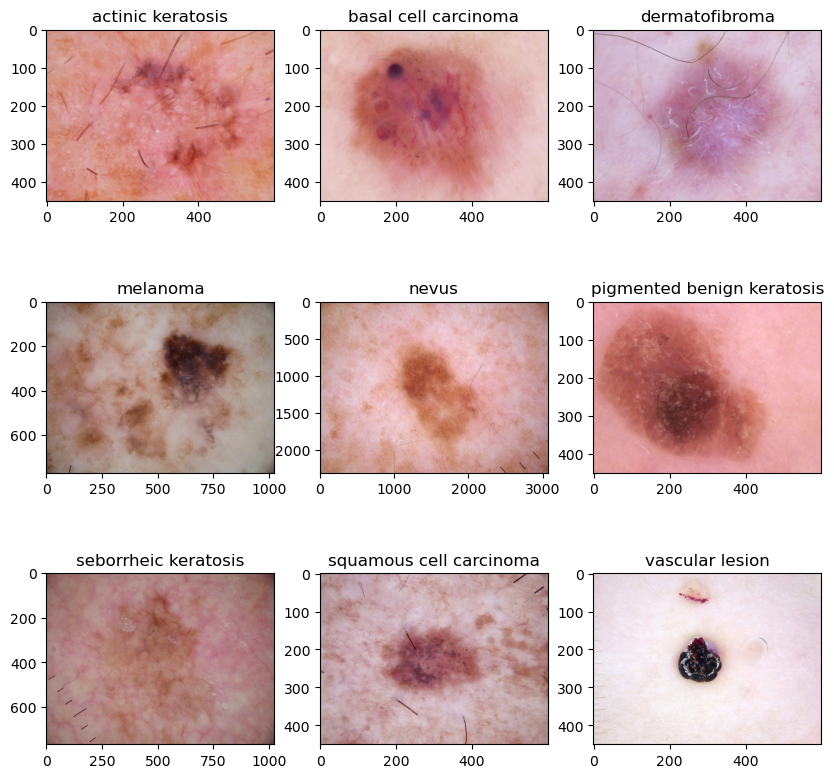

In [8]:
# Visualize one instance of all the nine classes present in the dataset
fig = plt.figure(figsize=(10,10))
for i in range(len(class_names)):
    cancer_cls_images = list(data_dir_train.glob(class_names[i] + '/*.jpg'))
    # Pick any random image of a particular cancer class
    rand_img_of_cancer_cls = cancer_cls_images[random.randint(0, len(cancer_cls_images)-1)]
    img_arr = plt.imread(rand_img_of_cancer_cls)
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(class_names[i])
    plt.imshow(img_arr)
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building
- Create an image rescaling layer which can be used as the first layer for all the models.

In [16]:
# Rescaling layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

### Model 1: Base Model

In [17]:
model = Sequential()
model.add(normalization_layer)

model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))

#### Compile the model

In [18]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [19]:
epochs = 20
history_1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\nandeesh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


281/281 [==============================] - 163s 576ms/step - loss: 1.7761 - accuracy: 0.3658 - val_loss: 1.3866 - val_accuracy: 0.4744
Epoch 2/20
281/281 [==============================] - 178s 634ms/step - loss: 1.1647 - accuracy: 0.5768 - val_loss: 1.0801 - val_accuracy: 0.5941
Epoch 3/20
281/281 [==============================] - 168s 600ms/step - loss: 0.8132 - accuracy: 0.7186 - val_loss: 0.8858 - val_accuracy: 0.6965
Epoch 4/20
281/281 [==============================] - 157s 559ms/step - loss: 0.5819 - accuracy: 0.8010 - val_loss: 0.7548 - val_accuracy: 0.7659
Epoch 5/20
281/281 [==============================] - 154s 547ms/step - loss: 0.4118 - accuracy: 0.8623 - val_loss: 0.7390 - val_accuracy: 0.7850
Epoch 6/20
281/281 [==============================] - 151s 537ms/step - loss: 0.3088 - accuracy: 0.8931 - val_loss: 0.6679 - val_accuracy: 0.8024
Epoch 7/20
281/281 [==============================] - 154s 548ms/step - loss: 0.2461 - accuracy: 0.9150 - val_loss: 0.6882 - val_accura

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 118336)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

#### Visualize the results

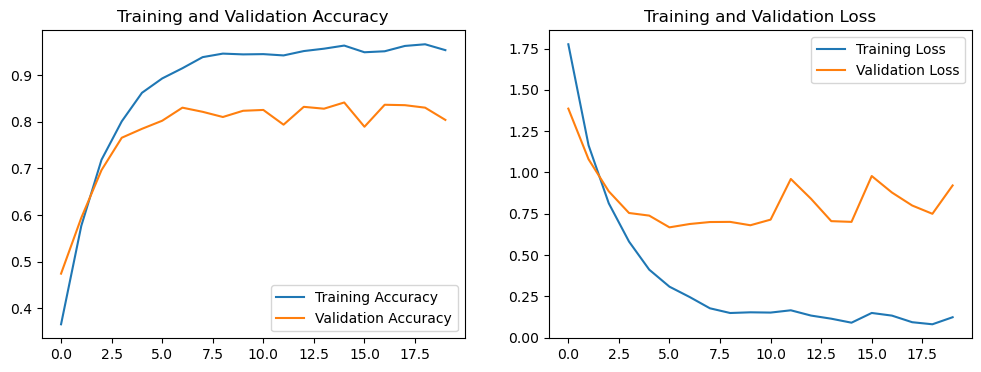

In [21]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**
- `Accuracy Plot`: The model is overfitting as it is evident from the accuracy plot that the model's training accuracy is steadily increasing while the validation accuracy remains ~50%.
- `Loss Plot`: The validation loss of a model increases with number of epochs and the training loss steadily decreases. This again indicates that the model is overfitting.
- We can infer from both the plots that the model predicts well for training data and fails to predict accurately for validation data.

### Model 2: Build a model using data augmentation technique to curb overfitting
- `Zoom`: This helps model to learn the texture in the image better. Since the data is of cancer images, zooming in will give a better clarity on how the cancerous skin texture looks like.
- `Flip` and `rotation`: This helps model not to memorize the image but rather learn the pattern out of the image.

In [22]:
augmentation_layers = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(height_factor= -0.3),
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
# Load any random image from the training set to see the difference between original and an augmented image.
list_of_images = list(data_dir_train.glob('*/*.jpg'))
rand_img = list_of_images[random.randint(0, len(list_of_images)-1)]
img_arr = plt.imread(rand_img)

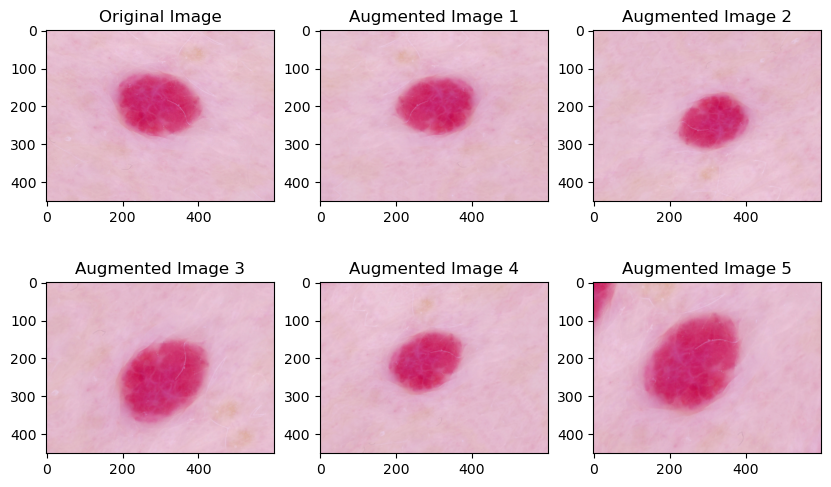

Image Path: ..\Skin\Train\vascular lesion\ISIC_0029608.jpg


In [24]:
img = tf.expand_dims(img_arr, 0)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(231)
ax.set_title('Original Image')
plt.imshow(img_arr)
for i in range(1, 6):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_title('Augmented Image ' + str(i))
    aug_img = augmentation_layers(img)
    plt.imshow(aug_img[0])
plt.show()
print('Image Path:', rand_img)

#### Create a model architecture using augmentation layer

In [25]:
model_2 = Sequential()
model_2.add(normalization_layer)
model_2.add(augmentation_layers)

model_2.add(Conv2D(32, 3, activation='relu'))
model_2.add(MaxPooling2D(2))

model_2.add(Conv2D(64, 3, activation='relu'))
model_2.add(MaxPooling2D(2))

model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_of_classes, activation='softmax'))

#### Compile the model

In [26]:
model_2.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

#### Train the model

In [27]:
epochs = 20
history_2 = model_2.fit(
     train_ds,
     validation_data=val_ds,
     epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 174s 616ms/step - loss: 1.9445 - accuracy: 0.2863 - val_loss: 1.5721 - val_accuracy: 0.3863
Epoch 2/20
281/281 [==============================] - 169s 602ms/step - loss: 1.6187 - accuracy: 0.3793 - val_loss: 1.4896 - val_accuracy: 0.4028
Epoch 3/20
281/281 [==============================] - 171s 607ms/step - loss: 1.5345 - accuracy: 0.3999 - val_loss: 1.3775 - val_accuracy: 0.4548
Epoch 4/20
281/281 [==============================] - 170s 605ms/step - loss: 1.4823 - accuracy: 0.4237 - val_loss: 1.3706 - val_accuracy: 0.4597
Epoch 5/20
281/281 [==============================] - 170s 606ms/step - loss: 1.4446 - accuracy: 0.4351 - val_loss: 1.3410 - val_accuracy: 0.4806
Epoch 6/20
281/281 [==============================] - 169s 602ms/step - loss: 1.4290 - accuracy: 0.4418 - val_loss: 1.2789 - val_accuracy: 0.4860
Epoch 7/20
281/281 [==============================] - 169s 602ms/step - loss: 1.3673 - accuracy: 0.4625 - val_loss: 1.2527 -

In [28]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 118336)           

#### Visualize the results

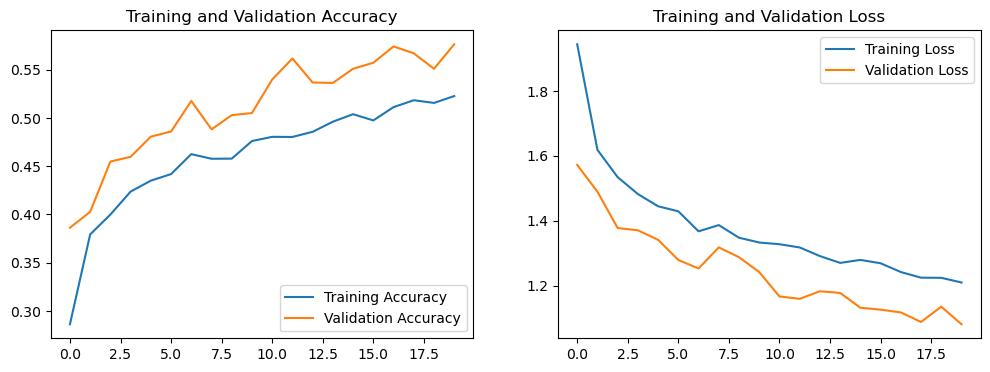

In [29]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**
- By using the augmentation layer, the model overfit has been handled since the testing accuracy is close to training accuracy.
- Since both the training and the testing accuracy is ~50%, the model is underfitting.

#### Find the distribution of classes in the training dataset.

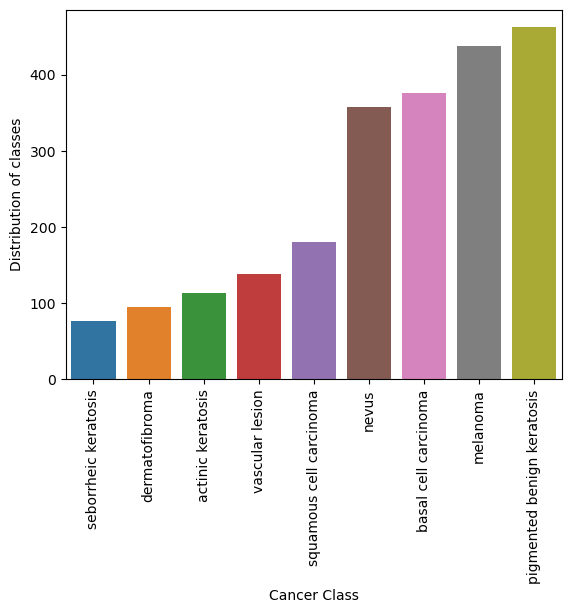

In [30]:
num_of_img_per_class = []
df = pd.DataFrame(columns=['classes', 'count'])
for i in range(len(class_names)):
    cancer_cls_images = list(data_dir_train.glob(class_names[i] + '/*.jpg'))
    num_of_img_per_class.append(len(cancer_cls_images))
df['classes'] = class_names
df['count'] = num_of_img_per_class
df.sort_values(by='count', ascending=True, inplace=True)
sns.barplot(x='classes', y='count', data=df)
plt.xticks(rotation=90)
plt.xlabel('Cancer Class')
plt.ylabel('Distribution of classes')
plt.show()

**Observations:**
- `seborrheic keratosis` class is having least number of samples.
- `pigmented benign keratosis` class is having high number of samples.
- It's clear that the dataset is imbalanced. To counter this problem, let's create augmented images to balance the dataset.

### Create a set of 500 augmented images for every class to handle class-imbalance and to counter model overfitting
To use `Augmentor`, the following general procedure is followed:
1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
for cls in class_names:
    p = Augmentor.Pipeline(source_directory=list(data_dir_train.glob(cls))[0])
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ..\Skin\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D54D59A700>: 100%|█| 500/500 [00:05<00:00, 98.44 Samples/


Initialised with 376 image(s) found.
Output directory set to ..\Skin\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D555D88D60>: 100%|█| 500/500 [00:05<00:00, 99.27 Samples/


Initialised with 95 image(s) found.
Output directory set to ..\Skin\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D54F53B130>: 100%|█| 500/500 [00:05<00:


Initialised with 438 image(s) found.
Output directory set to ..\Skin\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=965x624 at 0x1D552470DC0>: 100%|█| 500/500 [00:25<00:00, 19.44 Samples/


Initialised with 357 image(s) found.
Output directory set to ..\Skin\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x1D54E7D4820>: 100%|█| 500/500 [00:22<0


Initialised with 462 image(s) found.
Output directory set to ..\Skin\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D54F53BE80>: 100%|█| 500/500 [00:04<00:00, 102.68 Samples


Initialised with 77 image(s) found.
Output directory set to ..\Skin\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D55247A580>: 100%|█| 500/500 [00:10<00:00, 47.84 Samples


Initialised with 181 image(s) found.
Output directory set to ..\Skin\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D55256C6D0>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to ..\Skin\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D54D59ADC0>: 100%|█| 500/500 [00:05<00:00, 92.91 Samples/


#### Augmentor has stored the augmented images in the `output` sub-directory of each of the sub-directories of skin cancer types. Let's take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print('By creating 500 augmented images for 9 classes, the total images comes out to be', image_count_train)

By creating 500 augmented images for 9 classes, the total images comes out to be 13500


#### Let's see the distribution of augmented data after adding augmented images to the original training data.

In [33]:
# Extract paths of all the images (original + augmented).
orgnl_path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
aug_path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Get all the cancer class names from the images extracted.
orgnl_lesion_list = [os.path.basename(os.path.dirname(y)) for y in orgnl_path_list]
aug_lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in aug_path_list]

# Map the class names with the image path.
orgnl_img_mapper = dict(zip(orgnl_path_list, orgnl_lesion_list))
aug_img_mapper = dict(zip(aug_path_list, aug_lesion_list))

In [34]:
# Merge both augmented and original images into one dataframe.
orgnl_df = pd.DataFrame(list(orgnl_img_mapper.items()), columns = ['Path', 'Label'])
aug_df = pd.DataFrame(list(aug_img_mapper.items()), columns = ['Path', 'Label'])
final_df = orgnl_df.append(aug_df)
final_df.head()

,Path,Label
0,..\Skin\Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,..\Skin\Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,..\Skin\Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,..\Skin\Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,..\Skin\Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [35]:
# 500 images are augmented and rest are original images for every class.
final_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

**Observations:** Now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Model 3: Using augmented images for every lesion class

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create dataset

In [37]:
# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [38]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [39]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the model architecture

In [41]:
model_3 = Sequential()
model_3.add(normalization_layer)

model_3.add(Conv2D(32, 3, activation='relu'))
model_3.add(MaxPooling2D(2))
model_3.add(Dropout(0.1))

model_3.add(Conv2D(64, 3, activation='relu'))
model_3.add(MaxPooling2D(2))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_of_classes, activation='softmax'))

#### Compile the model

In [42]:
model_3.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#### Train the model

In [43]:
epochs = 30
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30


C:\Users\nandeesh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


394/394 [==============================] - 329s 755ms/step - loss: 1.8829 - accuracy: 0.3102 - val_loss: 1.4917 - val_accuracy: 0.4458
Epoch 2/30
394/394 [==============================] - 290s 736ms/step - loss: 1.4304 - accuracy: 0.4532 - val_loss: 1.2726 - val_accuracy: 0.5437
Epoch 3/30
394/394 [==============================] - 290s 736ms/step - loss: 1.2580 - accuracy: 0.5250 - val_loss: 1.0507 - val_accuracy: 0.6374
Epoch 4/30
394/394 [==============================] - 307s 779ms/step - loss: 1.0941 - accuracy: 0.5943 - val_loss: 1.0039 - val_accuracy: 0.6489
Epoch 5/30
394/394 [==============================] - 302s 766ms/step - loss: 0.9912 - accuracy: 0.6333 - val_loss: 0.8276 - val_accuracy: 0.7023
Epoch 6/30
394/394 [==============================] - 285s 725ms/step - loss: 0.8966 - accuracy: 0.6698 - val_loss: 0.7610 - val_accuracy: 0.7280
Epoch 7/30
394/394 [==============================] - 293s 743ms/step - loss: 0.7695 - accuracy: 0.7159 - val_loss: 0.6821 - val_accura

In [44]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43, 43, 64)       

#### Visualize the results

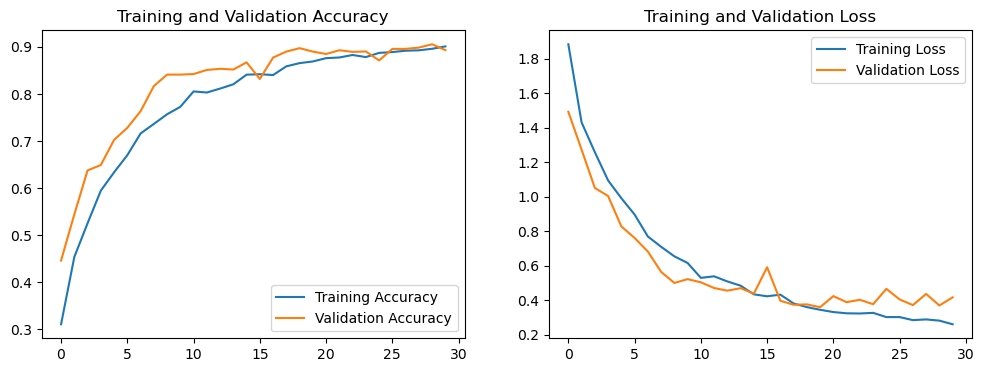

In [45]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**
- When compared to model 1 and model 2 which was exhibiting overfitting and underfitting respectively, model 3 exhibits decent performance thereby, handling underfitting and overfitting.
- Using class imbalance technique along with augmentation and dropout layers helped the model to learn and predict the cancer classes better than the other 2 models.